In [1]:
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd
import pupil_labs.video as plv
from utils import VideoHandler, write_worldtimestamp_csv
from optic_flow import OpticFlowCalculatorFarneback,OpticFlowCalculatorLK
from sync_videos import OffsetCalculator

Insert here the paths to the action camera video, to the neon scene video and to the worldtimestamps.csv of the Neon Timeseries

In [2]:
action_vid_path='/users/sof/gaze_mapping/raw_videos/InstaVid/wearingNeon_2m/AVun_20240216_160246_055.mp4'
neon_vid_path='/users/sof/gaze_mapping/raw_videos/Neon/Raw_Data/2024-02-16_wearingNeon/2024-02-16_15-58-13-6310bec3/cc00c32d_0.0-146.071.mp4'
neon_timestamps='/users/sof/gaze_mapping/raw_videos/Neon/Raw_Data/2024-02-16_wearingNeon/2024-02-16_15-58-13-6310bec3/world_timestamps.csv'

## Video Handler

In [3]:
actionVid = VideoHandler(video_dir=action_vid_path)
print(f'Action video:\n -Height: {actionVid.height}\n -Width: {actionVid.width}')


Action video:
 -Height: 1080
 -Width: 1920


In [ ]:
selected_timestamps=actionVid.get_timestamps_in_interval(0,5)
for i in selected_timestamps:
    action_frame = actionVid.get_frame_by_timestamp(i)

In [4]:
neonVid=VideoHandler(video_dir=neon_vid_path)
print(f'Neon video:\n -Height: {neonVid.height}\n -Width: {neonVid.width}')

Neon video:
 -Height: 1200
 -Width: 1600


(-0.1, 3.0)

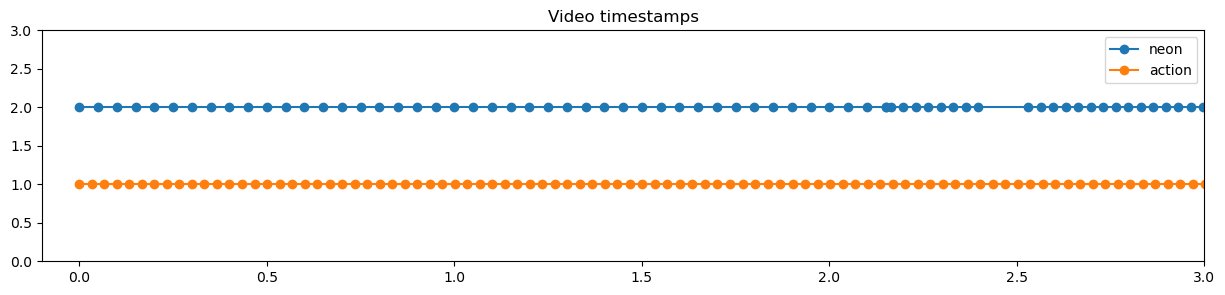

In [15]:
plt.figure(figsize=(15,3))
plt.title('Video timestamps')
plt.plot(neonVid.timestamps,np.ones_like(neonVid.timestamps)*2,'-o',label='neon')
plt.plot(actionVid.timestamps,np.ones_like(actionVid.timestamps),'-o',label='action')
plt.legend()
plt.ylim(0,3)
plt.xlim(-0.1,3)

Text(0.5, 1.0, 'Action')

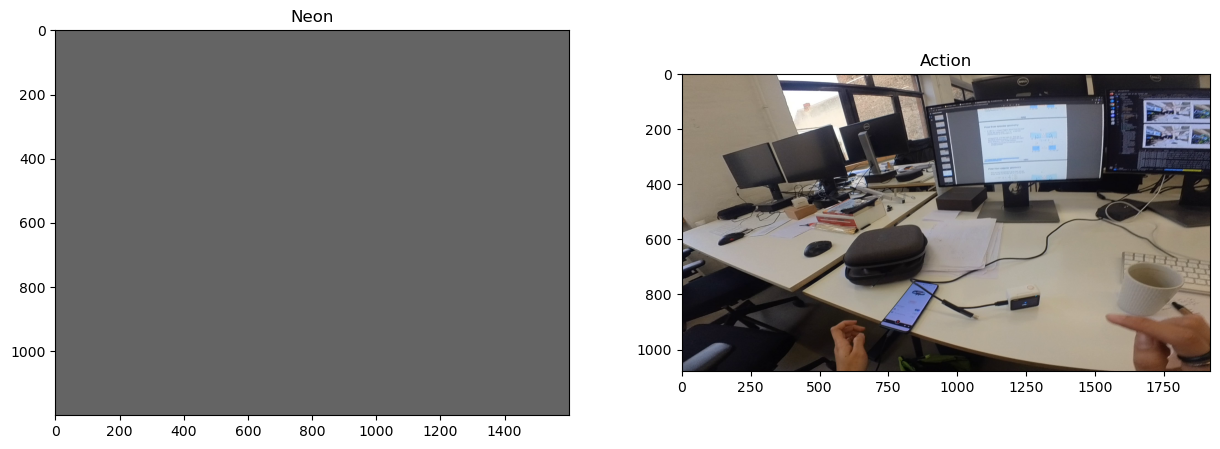

In [16]:
neonframe = neonVid.get_frame_by_timestamp(neonVid.timestamps[0])
actionframe = actionVid.get_frame_by_timestamp(actionVid.timestamps[0])
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(neonframe)
plt.title('Neon')
plt.subplot(1,2,2)
plt.imshow(actionframe)
plt.title('Action')

## Optic Flow

In [4]:
action_of = OpticFlowCalculatorFarneback(video_dir=action_vid_path)
neon_of = OpticFlowCalculatorFarneback(video_dir=neon_vid_path)

In [5]:
ac_result = action_of.get_optic_flow(start_time=0,end_time=5)
neon_result = neon_of.get_optic_flow(0,5)

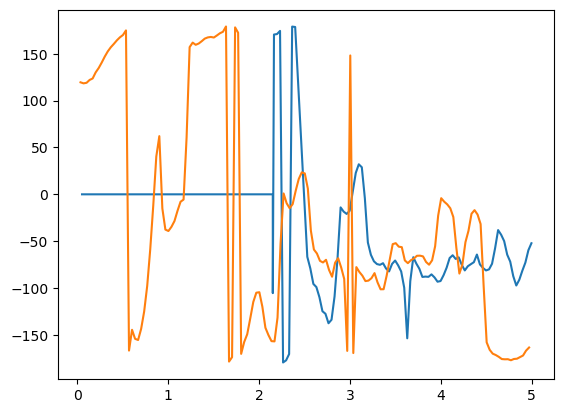

In [6]:
plt.plot(neon_result['end'].values,np.rad2deg(neon_result['angle'].values),label='neon')
plt.plot(ac_result['end'].values,np.rad2deg(ac_result['angle'].values),label='action')

## Offset Calculator

Estimated offset: 0.622 seconds (Pearson correlation: 0.6253388212846374)


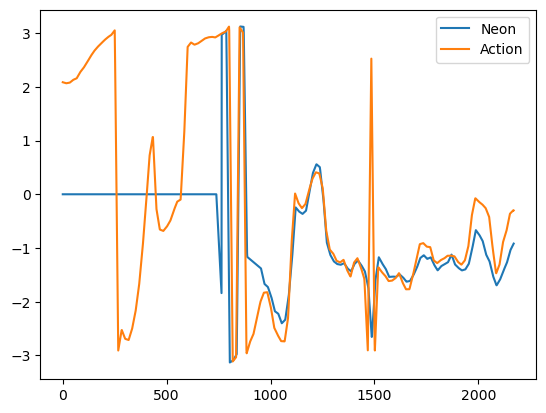

In [7]:
offset_calc=OffsetCalculator(source=ac_result['angle'].values,source_timestamps=ac_result['start'].values, destination=neon_result['angle'].values, destination_timestamps=neon_result['start'].values,resampling_frequency=500)
t_offset, pearson_corr = offset_calc.estimate_time_offset()
print(f'Estimated offset: {t_offset} seconds (Pearson correlation: {pearson_corr})')
start,end = None,None
idx=offset_calc._obtain_indexes(offset_calc.source_resampled_timestamps,start,end)
x_cor,lags=offset_calc._cross_correlate(offset_calc.source_resampled[idx[0]:idx[1]])
s_offset = lags[np.argmax(x_cor)]
s,d=offset_calc._obtain_overlapping_signals(s_offset,offset_calc.source_resampled[idx[0]:idx[1]])
plt.figure()
plt.plot(d,label='Neon')
plt.plot(s, label='Action')
plt.legend()


Estimated offset: 0.6240000000000001 seconds (Pearson correlation: 0.7188746996634156)


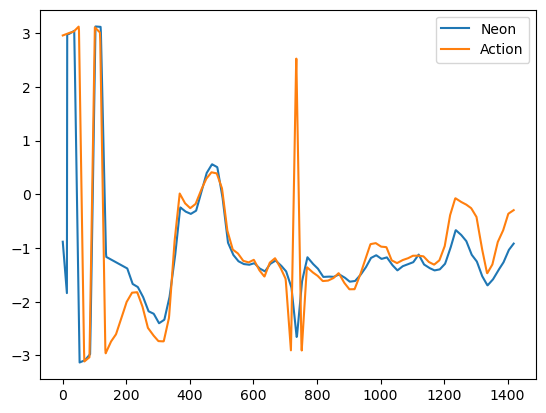

In [8]:
start,end = 1.5,None
t_offset, pearson_corr = offset_calc.estimate_time_offset(source_end_time=end, source_start_time=start)
print(f'Estimated offset: {t_offset} seconds (Pearson correlation: {pearson_corr})')
idx=offset_calc._obtain_indexes(offset_calc.source_resampled_timestamps,start,end)
x_cor,lags=offset_calc._cross_correlate(offset_calc.source_resampled[idx[0]:idx[1]])
s_offset = lags[np.argmax(x_cor)]
s,d=offset_calc._obtain_overlapping_signals(s_offset,offset_calc.source_resampled[idx[0]:idx[1]])
plt.figure()
plt.plot(d, label='Neon')
plt.plot(s,label='Action')
plt.legend()

Comparing it with the previously calculated optic flow signal 

Insert here the path to the saved optic flow of the corresponding pair of videos

In [5]:
previous_optic_flow_path = '/users/sof/gaze_mapping/synchronization/optic_flow/wearingNeon_unstable_grid_opticflow.pkl'

Start of Optic Flow in neon video: 2.163144448s (frame number 45)
Start of Optic Flow in action video: 0.03336666666666667s (frame number 1)


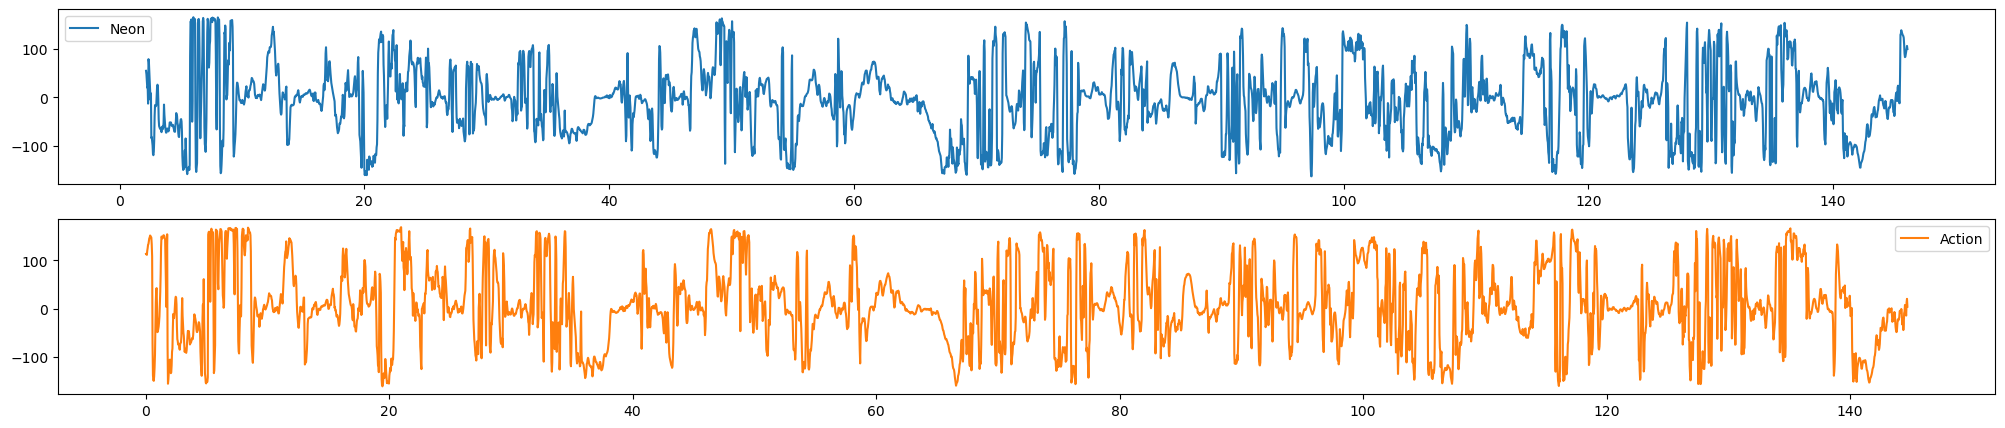

In [6]:
optic=pd.read_pickle(previous_optic_flow_path)
neon_optic=pd.DataFrame({k:v for k,v in optic.items() if 'neon' in k})
action_optic=pd.DataFrame({k:v for k,v in optic.items() if 'action' in k})
df = pd.read_csv(neon_timestamps)
t_neon = df["timestamp [ns]"].values.astype(np.float64)
t_neon -= t_neon[0]
t_neon /= 1e9
#timestamps for action cam video
recording_action = plv.open(action_vid_path)
pts_action = np.asarray(recording_action.streams[0].pts)
t_action=pts_action/recording_action.streams[0].time_base.denominator
print(f'Start of Optic Flow in neon video: {t_neon[neon_optic["neon frame"].iloc[0]]}s (frame number {neon_optic["neon frame"].iloc[0]})')
print(f'Start of Optic Flow in action video: {t_action[action_optic["action frame"].iloc[0]]}s (frame number {action_optic["action frame"].iloc[0]})')
useful_t_neon = t_neon[neon_optic['neon frame'].iloc[0]:neon_optic['neon frame'].iloc[-1]+1]
useful_t_action = t_action[action_optic['action frame'].iloc[0]:action_optic['action frame'].iloc[-1]+1]

plt.figure(figsize=(25,5)) 
plt.subplot(2,1,1)
plt.plot(useful_t_neon,neon_optic['neon angle'],label='Neon')
plt.legend()
plt.subplot(2,1,2)
plt.plot(useful_t_action,action_optic['action angle'],color=mcolors.TABLEAU_COLORS['tab:orange'],label='Action')
plt.legend()

Estimated offset: 0.6277777813333334 seconds (Pearson correlation: 0.8934046841736759)
Estimated offset: 0.6297777813333307 seconds (Pearson correlation: 0.9149100641574144)


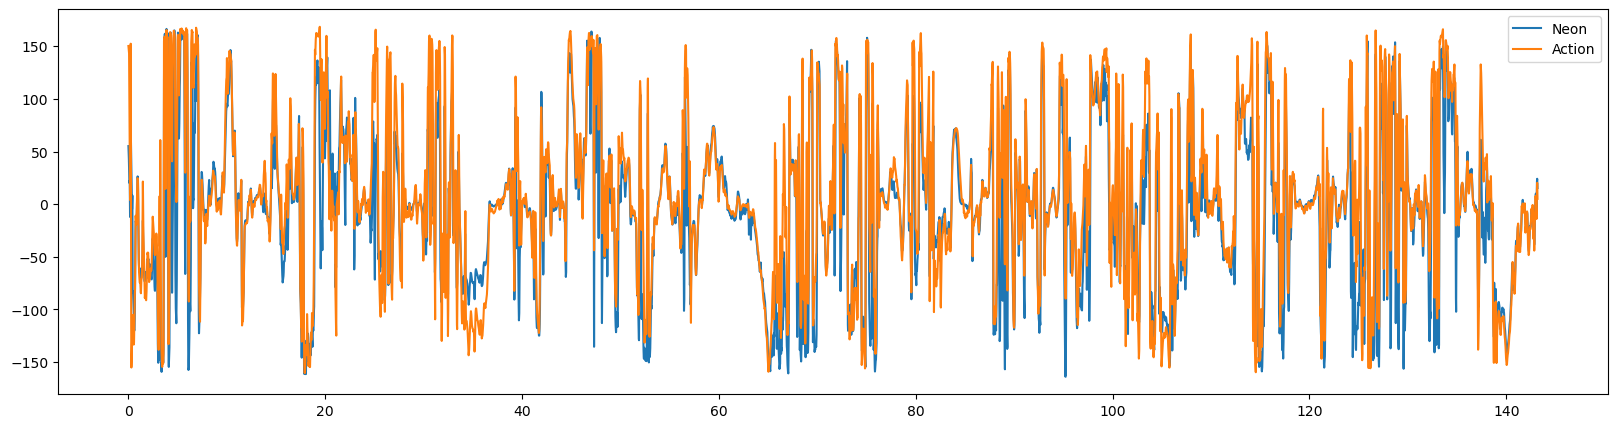

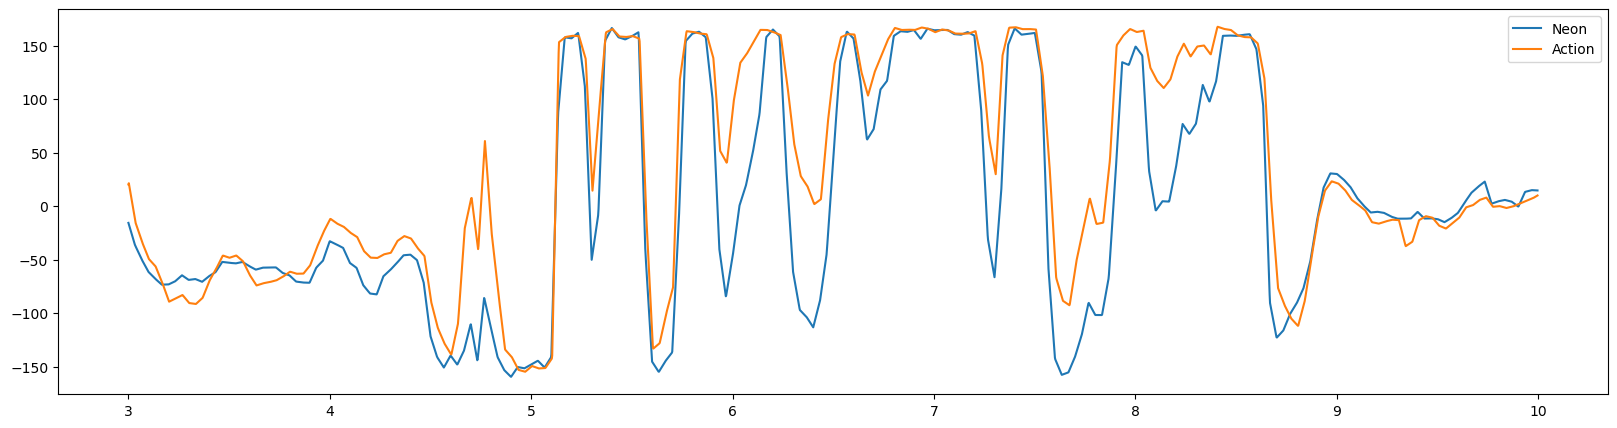

In [7]:
offset_calc2 = OffsetCalculator(source=action_optic['action angle'].values,source_timestamps=useful_t_action, destination=neon_optic['neon angle'].values, destination_timestamps = useful_t_neon,resampling_frequency=500)
t_offset,pearson_corr = offset_calc2.estimate_time_offset()
print(f'Estimated offset: {t_offset} seconds (Pearson correlation: {pearson_corr})')

start,end = None,None
idx=offset_calc2._obtain_indexes(offset_calc2.source_resampled_timestamps,start,end)
x_cor,lags=offset_calc2._cross_correlate(offset_calc2.source_resampled[idx[0]:idx[1]])
s_offset = lags[np.argmax(x_cor)]
s,d=offset_calc2._obtain_overlapping_signals(s_offset,offset_calc2.source_resampled[idx[0]:idx[1]])
plt.figure(figsize=(20,5))
plt.plot(np.arange(len(d))/offset_calc2.resampling_frequency,d, label='Neon')
plt.plot(np.arange(len(s))/offset_calc2.resampling_frequency,s,label='Action')
plt.legend()

start,end = 3,10
t_offset,pearson_corr = offset_calc2.estimate_time_offset(source_end_time=end, source_start_time=start)
print(f'Estimated offset: {t_offset} seconds (Pearson correlation: {pearson_corr})')
idx=offset_calc2._obtain_indexes(offset_calc2.source_resampled_timestamps,start,end)
x_cor,lags=offset_calc2._cross_correlate(offset_calc2.source_resampled[idx[0]:idx[1]])
s_offset = lags[np.argmax(x_cor)]
s,d=offset_calc2._obtain_overlapping_signals(s_offset,offset_calc2.source_resampled[idx[0]:idx[1]])
plt.figure(figsize=(20,5))
plt.plot(np.arange(len(d))/offset_calc2.resampling_frequency+start,d, label='Neon')
plt.plot(np.arange(len(s))/offset_calc2.resampling_frequency+start,s,label='Action')
plt.legend()


## Creation of action_world_timestamps.csv

In [8]:
write_worldtimestamp_csv(world_timestamps_dir=neon_timestamps, relative_timestamps=actionVid.timestamps, time_delay=t_offset)
neon_worldts = pd.read_csv(neon_timestamps)
action_worldts = pd.read_csv(neon_timestamps.replace('world_timestamps.csv','action_camera_world_timestamps.csv'))

World timestamps for action camera recording saved at /users/sof/gaze_mapping/raw_videos/Neon/Raw_Data/2024-02-16_wearingNeon/2024-02-16_15-58-13-6310bec3/action_camera_world_timestamps.csv


(1.708095493929e+18, 1.7080954962588557e+18)

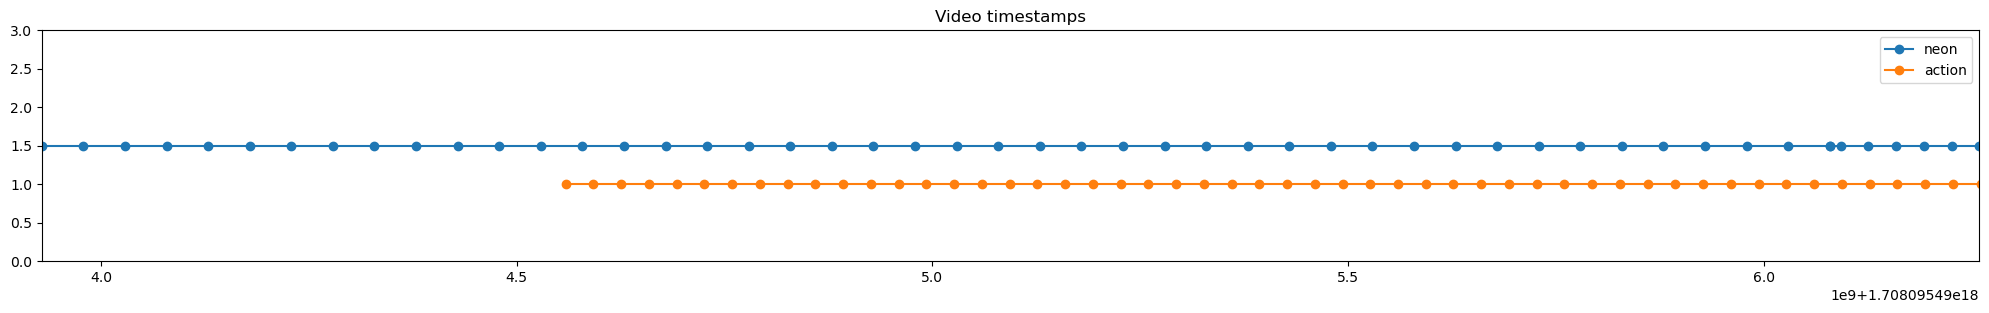

In [30]:
plt.figure(figsize=(25,3))
plt.title('Video timestamps')
plt.plot(neon_worldts['timestamp [ns]'].values,np.ones_like(neon_worldts['timestamp [ns]'].values)*1.5,'-o',label='neon')
plt.plot(action_worldts['timestamp [ns]'].values,np.ones_like(action_worldts['timestamp [ns]'].values),'-o',label='action')
plt.legend()
plt.ylim(0,3)
plt.xlim(neon_worldts['timestamp [ns]'].values[0],neon_worldts['timestamp [ns]'].values[50])

If we take a random world timestamp from the Neon Scene recording, the action worldtimestamp dataframe can be queried to obtain the index of the closest action worldtimestamp. (Datetime printed just to show it is indeed the closest frame in the other video)

In [70]:
neon_idx=45
random_neon_ts=neon_worldts['timestamp [ns]'].values[neon_idx]

index_action=np.argmin(np.abs(action_worldts['timestamp [ns]'].values - random_neon_ts))
corresponding_action_ts = action_worldts['timestamp [ns]'].iloc[index_action]

print(f"Neon date.time: {pd.Timestamp(random_neon_ts,unit='ns')}, at index {neon_idx}")
print(f"Action date.time: {pd.Timestamp(corresponding_action_ts,unit='ns')}, at index {index_action}")

Neon date.time: 2024-02-16 14:58:16.092144444, at index 45
Action date.time: 2024-02-16 14:58:16.093644608, at index 46


Text(0.5, 1.0, 'Action')

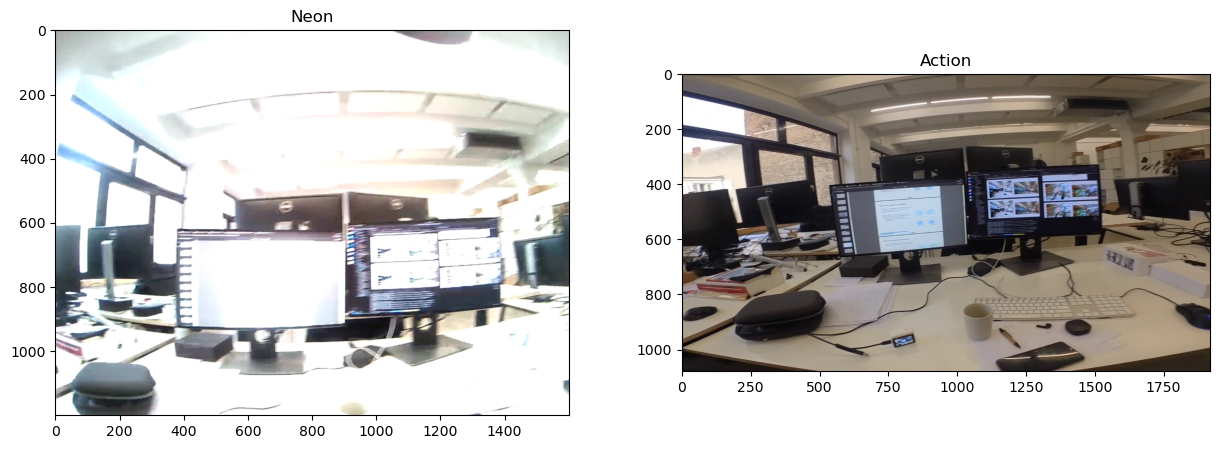

In [63]:
actionVid = VideoHandler(video_dir=action_vid_path)
neonVid=VideoHandler(video_dir=neon_vid_path)

neonframe = neonVid.get_frame_by_timestamp(neonVid.timestamps[neon_idx])
actionframe = actionVid.get_frame_by_timestamp(actionVid.timestamps[index_action])
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(neonframe)
plt.title('Neon')
plt.subplot(1,2,2)
plt.imshow(actionframe)
plt.title('Action')

Even easier, we can take advantage of the get_closest_timestamp method in VideoHandler.

Given two world_timestamp files, the delay between the videos can be recovered. 
Throughout all the project, the Neon recording is treated as the 'relative zero'. So to get the neon relative timestamp, it is just enough with substracting the first neon worldtimestamp value and then converting it to seconds.

The action worldtimestamps were calculated by adding the offset value given by the OffsetCalculator() to the action relative timestamps and then adding the first neon worldtimestamp value. So to recover the offset, it just suffices to substract the value of the first Neon worldtimestamp to the first action worldtimestamp value and then converting it to seconds.

So with the action offset value, it is as simple as substracting this offset to the neon relative timestamp and giving the resulting value to the get_frame_by_timestamp method of the action VideoHandler (THIS METHOD CALLS INTERNALLY FOR get_closest_timestamp).

In [64]:
random_neon_relative_ts=(random_neon_ts-neon_worldts['timestamp [ns]'].values[0])/1e9
print(f'Random relative neon timestamp: {random_neon_relative_ts}s')
action_offset =  action_worldts['timestamp [ns]'].values[0] - neon_worldts['timestamp [ns]'].values[0]
action_offset/=1e9
print(f'Offset from the csv files: {action_offset}s\nOffset from the offset_calculator: {t_offset}s')

Random realtive neon timestamp: 2.163144444s
Offset from the csv files: 0.629777792s
Offset from the offset_calculator: 0.6297777813333307s


a.Time value found by querying the action worldtimestamps dataframe: 1.5348666906356812
b.This time value is given to the actionVid object: 1.5333666519999998
c.Time value found by giving value in b to get_closest_timestamp in the actionVid object: 1.5348666906356812


Text(0.5, 1.0, 'Action')

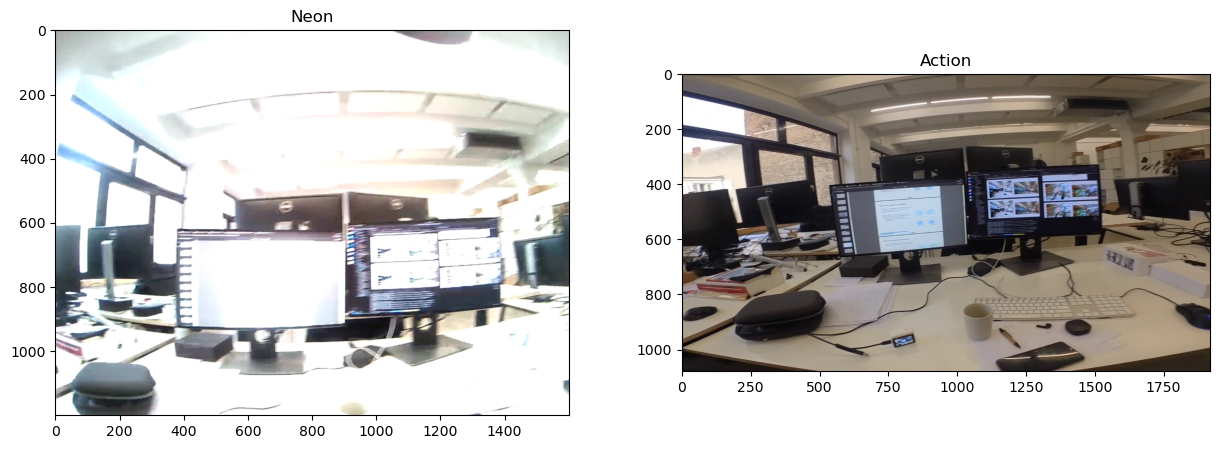

In [68]:
actionVid = VideoHandler(video_dir=action_vid_path)
neonVid=VideoHandler(video_dir=neon_vid_path)

print(f'a.Time value found by querying the action worldtimestamps dataframe: {actionVid.timestamps[index_action]}')
print(f'b.This time value is given to the actionVid object: {random_neon_relative_ts-action_offset}')
print(f'c.Time value found by giving value in b to get_closest_timestamp in the actionVid object: {actionVid.get_closest_timestamp(random_neon_relative_ts-action_offset)}')
neonframe = neonVid.get_frame_by_timestamp(random_neon_relative_ts)
actionframe = actionVid.get_frame_by_timestamp(random_neon_relative_ts-action_offset)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(neonframe)
plt.title('Neon')
plt.subplot(1,2,2)
plt.imshow(actionframe)
plt.title('Action')